# Task 2 

## Problem Statement

_Implement a circuit that returns $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability._

**Requirements:**
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

**Bonus question:
How to make sure you produce state $\lvert01\rangle$ + $\lvert10\rangle$ and not $\lvert01\rangle$ - $\lvert10\rangle$?**

---

I've decided to use **Qiskit 0.20.0** for this task - it's the one I'm most comfortable with. Version details follow...

In [7]:
%autosave 15
import qiskit
qiskit.__qiskit_version__

Autosaving every 15 seconds


{'qiskit-terra': '0.15.1',
 'qiskit-aer': '0.6.1',
 'qiskit-ignis': '0.4.0',
 'qiskit-ibmq-provider': '0.8.0',
 'qiskit-aqua': '0.7.5',
 'qiskit': '0.20.0'}

## 1. Creating a reference circuit

For starters, I decided to make a reference circuit that creates the state $\lvert\psi\rangle = \frac{1}{\sqrt{2}}\lvert01\rangle + \frac{1}{\sqrt{2}}\lvert10\rangle$ (upto a global phase) using only RX, RY, and CX gates. The intention behind this was just to get a feel of the RX and RY gates and do some visualization...

In [8]:
# imports and general configuration
import random
import numpy as np

from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_state_qsphere as plot_q
from qiskit.quantum_info import Statevector
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

config = {
    'output': 'mpl',
    'qsphere_fig_size': (6.5, 6.5)
}

statevector_sim = Aer.get_backend('statevector_simulator')
qasm_sim = Aer.get_backend('qasm_simulator')

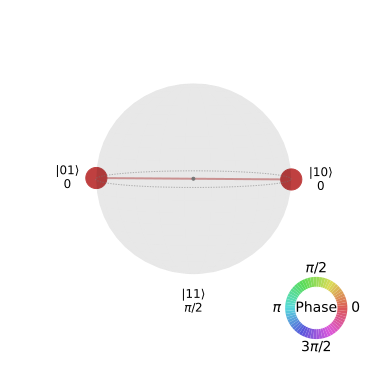

In [9]:
t2_ref_ckt = QuantumCircuit(2)

# X gate on qubit 1
t2_ref_ckt.rx(np.pi, 1)
# Hadamard on qubit 0
t2_ref_ckt.ry(np.pi/2, 0) 
t2_ref_ckt.rx(np.pi, 0)

# CNOT with qubit 0 as control and qubit 1 as target
t2_ref_ckt.cx(0,1)

# evolving the Statevector() using the QuantumCircuit() to reach the final state
# this way there's no need for a simulator 
ref_sv = Statevector.from_label('00').evolve(t2_ref_ckt)

# plot the state on the q-sphere for visualization
plot_q(ref_sv, figsize=config['qsphere_fig_size'], show_state_phases=True)

## 2. Approach

This first approach is straightforward. The order of the gates is fixed and I'm attempting to learn the parameters of the RX and RY gates using Gradient Descent...  

In order to measure $\lvert01\rangle$ and $\lvert10\rangle$ with equal probability, we must generate a state 
$$
\lvert\psi\rangle = \alpha\lvert01\rangle + \beta\lvert10\rangle
$$
satisfying
$$
\left\lVert\alpha^2\right\rVert = \left\lVert\beta^2\right\rVert = 0.5
$$

The easiest way to generate this state is to first create $\lvert\psi^\prime\rangle = \alpha\lvert01\rangle + \beta\lvert11\rangle = \big(\alpha\lvert0\rangle + \beta\lvert1\rangle \big) \otimes\lvert1\rangle$, and then apply a CX gate to this state controlled on the first qubit and targeting the second.

The state $\big(\alpha\lvert0\rangle + \beta\lvert1\rangle \big) \otimes\lvert1\rangle$ is (obviously) completely separable, which means I can treat each qubit individually and optimize one at a time.  
  
**In this case, the  first qubit must, at the end of the circuit, give you an equal probability of measuring $\lvert0\rangle$ (eigen value 1) and $\lvert1\rangle$ (eigen value -1).  
The second qubit must end up in the state $\lvert1\rangle$ (upto a global phase).**

Given the restriction that I can use only $RY(\theta)$ and $RX(\theta)$ gates, I decided to fix the structure of the circuit as shown below...

Circuit created with random initialization of parameters...


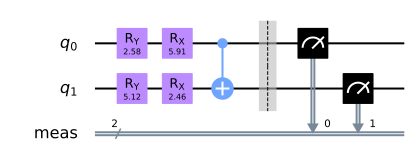

In [10]:
# Initialize random circuit parameters

# q0_thetas is a list of 2 angles (between 0 and 2*pi) which parametrize the RY and RX gates on qubit 1 respectively
q1_thetas = 2 * np.pi * np.random.rand(2)
# same as q1_thetas but for qubit 2
q2_thetas = 2 * np.pi * np.random.rand(2)

t2_ckt = QuantumCircuit(2)

t2_ckt.ry(q1_thetas[0], 0)
t2_ckt.rx(q1_thetas[1], 0)

t2_ckt.ry(q2_thetas[0], 1)
t2_ckt.rx(q2_thetas[1], 1)

t2_ckt.cx(0, 1)

t2_ckt.measure_all()
print("Circuit created with random initialization of parameters...")
t2_ckt.draw('mpl')

---

## 2.1. Calculation

Gradient Descent is a fairly simple algorithm to implement from scratch. Since we're working with individual qubits and optimizing over 2 gates only, it is easy to construct the unitary matrix representing the effect of the circuit on each qubit.  
  
  
Let $\theta_1$ be the rotation angle of the $RY$ Gate, and $\theta_2$ be the rotation angle of the $RX$ Gate.
  
The unitary matrices corresponding to the $RY$ and $RX$ gates are given by:
$$
\begin{aligned}
    RY(\theta_1) & = 
    \begin{bmatrix} 
        cos(\frac{\theta_1}{2}) & -sin(\frac{\theta_1}{2}) \\ 
        -sin(\frac{\theta_1}{2}) & cos(\frac{\theta_1}{2})
    \end{bmatrix}\\
    RX(\theta_2) & = 
    \begin{bmatrix} 
        cos(\frac{\theta_2}{2}) & -isin(\frac{\theta_2}{2}) \\ 
        -isin(\frac{\theta_2}{2}) & cos(\frac{\theta_2}{2})
    \end{bmatrix}\\
\end{aligned}
$$  

### Arriving at the final state in terms of parameters $\theta_1$ and $\theta_2$:
  
We start in the state $\lvert0\rangle = \begin{bmatrix} 1\\0 \end{bmatrix}$, and then apply $RY(\theta_1)$ followed by $RX(\theta_2)$...

$$
\begin{bmatrix} 
    1 \\
    0 
\end{bmatrix}
\xrightarrow{RY(\theta_1)}
\begin{bmatrix} 
    cos(\frac{\theta_1}{2}) \\
    -sin(\frac{\theta_1}{2})
\end{bmatrix}
\xrightarrow{RX(\theta_2)}
\begin{bmatrix} 
    cos(\frac{\theta_1}{2})cos(\frac{\theta_2}{2}) + isin(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) \\
    -icos(\frac{\theta_1}{2})sin(\frac{\theta_2}{2}) - sin(\frac{\theta_1}{2})cos(\frac{\theta_2}{2})
\end{bmatrix}
$$

### Probabilities of measuring $\lvert0\rangle$ and $\lvert1\rangle$:
$$
\begin{aligned}
P_0 & = cos^2(\frac{\theta_1}{2})cos^2(\frac{\theta_2}{2}) + sin^2(\frac{\theta_1}{2})sin^2(\frac{\theta_2}{2}) \\
P_1 & = cos^2(\frac{\theta_1}{2})sin^2(\frac{\theta_2}{2}) + sin^2(\frac{\theta_1}{2})cos^2(\frac{\theta_2}{2})
\end{aligned}
$$

### Cost Function:

The cost function must be one that penalizes a circuit which yields measurement probabilities that we don't want.

#### For qubit 0:
We want qubit 0 to end up in a state with equal probabilities ($\frac{1}{2}$ each) of measuring $\lvert0\rangle$ and $\lvert1\rangle$. So a reasonable cost function is:
$$
J = \frac{1}{2}(P_0 - 0.5)^2 + \frac{1}{2}(P_1 - 0.5)^2
$$

#### For qubit 1:
We want qubit 1 to end up in the state $\lvert1\rangle$, so we would like $P_0$ to be $0$ and $P_1$ to be $1$: 
$$
J = \frac{1}{2}(P_0)^2 + \frac{1}{2}(P_1 - 1)^2
$$  
where the factors of $\frac{1}{2}$ are taken for convenience with derivatives...  
<font color=green>Because we're starting out in a state along the Z-axis of the Bloch sphere, and applying rotations along the X and Y axes, the 2 rotations effectively act independently, and so we can optimize them independently without having to worry about backpropagation of errors.</font>
  
  
### Partial Derivatives

At any step during the optimization, gradient descent changes the values of each parameter by an amount proportional to the partial derivative of the cost function with respect to that parameter at that point.  
  
The partial derivatives of the cost function are given by -  
**for qubit 1:**
$ \frac{\partial J}{\partial \theta_1} = \bigg( \frac{1}{2} * 2 * (P_0 - 0.5) * \frac{\partial P_0}{\partial \theta_1}\bigg) + \bigg( \frac{1}{2} * 2 * (P_1 - 0.5) * \frac{\partial P_1}{\partial \theta_1}\bigg) = (P_0 - 0.5) * \frac{\partial P_0}{\partial \theta_1} + (P_1 - 0.5) * \frac{\partial P_1}{\partial \theta_1}$  
  
**for qubit 2:**
$ \frac{\partial J}{\partial \theta_1} = \bigg( \frac{1}{2} * 2 * (P_0) * \frac{\partial P_0}{\partial \theta_1}\bigg) + \bigg( \frac{1}{2} * 2 * (P_1 - 1) * \frac{\partial P_1}{\partial \theta_1}\bigg) = (P_0) * \frac{\partial P_0}{\partial \theta_1} + (P_1 - 1) * \frac{\partial P_1}{\partial \theta_1}$
  
### Calculations for $ \frac{\partial P_i}{\partial \theta_j} $:
    
$$
\begin{aligned}
    \frac{\partial P_0}{\partial \theta_1} & = -sin\theta_1cos^2\frac{\theta_2}{2} + sin\theta_1sin^2\frac{\theta_2}{2} \\
    & = -sin\theta_1\big(cos^2\frac{\theta_2}{2} - sin^2\frac{\theta_2}{2}\big) \\
    & = -sin\theta_1cos\theta_2 \\
    \\
    \frac{\partial P_0}{\partial \theta_2} & = -cos^2\frac{\theta_1}{2}sin\theta_2 + sin^2\frac{\theta_1}{2}sin\theta_2 \\
    & = -cos\theta_1sin\theta_2 \\
    \\
    \frac{\partial P_1}{\partial \theta_1} & = cos^2\frac{\theta_2}{2}sin\theta_1 - sin^2\frac{\theta_2}{2}sin\theta_1 \\
    & = sin\theta_1cos\theta_2 \\
    \\
    \frac{\partial P_1}{\partial \theta_2} & = -sin^2\frac{\theta_1}{2}sin\theta_2 + cos^2\frac{\theta_1}{2}sin\theta_2 \\
    & = cos\theta_1sin\theta_2 \\
\end{aligned}
$$
  
  
#### Substituting these values:  
**for qubit 1:**  
$\frac{\partial J}{\partial \theta_1} = sin\theta_1cos\theta_2(P_1-P_0)$
  
and  

$\frac{\partial J}{\partial \theta_2} = sin\theta_2cos\theta_1(P_1-P_0)$  
  
**for qubit 2:**  
$\frac{\partial J}{\partial \theta_1} = sin\theta_1cos\theta_2(P_1 - P_0 - 1)$
  
and  

$\frac{\partial J}{\partial \theta_2} = sin\theta_2cos\theta_1(P_1 - P_0 - 1)$  

---

We can now write helper functions to create the circuit, compute the costs and gradients, and to retrieve p0 and p1 from the Result object...

In [11]:
def create_circuit(thetas):
    
    ckt = QuantumCircuit(1)
    ckt.ry(thetas[0], 0)
    ckt.rx(thetas[1], 0)
    ckt.measure_all()

    return ckt

def compute_cost_qubit1 (p0, p1):
    return ((p0 - 0.5) ** 2 + (p1 - 0.5) ** 2) / 2

def compute_cost_qubit2 (p0, p1):
    return ((p0) ** 2 + (p1 - 1) ** 2) / 2

def compute_gradient_qubit1(learning_rate, thetas, p0, p1):
    grad_1 = np.sin(thetas[0]) * np.cos(thetas[1]) * (p1 - p0)
    grad_2 = np.sin(thetas[1]) * np.cos(thetas[0]) * (p1 - p0)
    return [learning_rate * grad_1, learning_rate * grad_2]

def compute_gradient_qubit2(learning_rate, thetas, p0, p1):
    grad_1 = np.sin(thetas[0]) * np.cos(thetas[1]) * (p1 - p0 - 1)
    grad_2 = np.sin(thetas[1]) * np.cos(thetas[0]) * (p1 - p0 - 1)
    return [learning_rate * grad_1, learning_rate * grad_2]

def get_probabilities (result, shots):
    counts = result.get_counts()
    try:
        p0 = counts['0'] / shots
    except:
        p0 = 0
    
    try:
        p1 = counts['1'] / shots
    except:
        p1 = 0
    return (p0, p1)

We also need a function that will carry out gradient descent to optimize $\theta_1$ and $\theta_2$ on a given single qubit circuit...

In [15]:
# learning rate
alpha = 0.1
# number of steps
iterations = 10001
# values for number of measurement shots per iteration
shots = [1, 10, 100, 1000]

In [16]:
def optimize_angles(circuit, thetas, shots, compute_gradient, compute_cost):
    
    print("\n==============================\n")
    print("Optimizing with shots = {} ...".format(shots))
    print("\n==============================\n")
    
    for iteration in range(iterations):
    
        result = execute(circuit, backend=qasm_sim, shots=shots).result()

        (p0, p1) = get_probabilities(result, shots)
        cost = compute_cost(p0, p1)

        # Compute Gradient
        delta = compute_gradient(alpha, thetas, p0, p1)
        
        # Update angles
        thetas = thetas - delta
        
        if iteration % 1 == 0:
            print ("\nIteration {} | Cost = {:.5e}".format(iteration, cost))
            print("Gradient: ", delta)
            print("Updated angles: ", thetas)

        circuit = create_circuit(thetas)
    
    return circuit, thetas

---

## 2.2. Qubit 1

Optimizing $\theta_1$ and $\theta_2$ for qubit 1, which should give us $\lvert0\rangle$ and $\lvert1\rangle$ with equal probabilities... 

In [17]:
qubit1_results = []

for num_shots in shots:
    
    q1_thetas = 2 * np.pi * np.random.rand(2)
    q1_ckt = create_circuit(q1_thetas)
    q1_ckt, q1_thetas = optimize_angles(q1_ckt, q1_thetas, num_shots, compute_gradient_qubit1, compute_cost_qubit1)
    
    qubit1_results.append({'circuit': q1_ckt, 'angles': q1_thetas})



Optimizing with shots = 1 ...



Iteration 0 | Cost = 2.50000e-01
Gradient:  [-0.00358069982476594, 0.01727516334588394]
Updated angles:  [3.18153566 2.95057885]

Iteration 1 | Cost = 2.50000e-01
Gradient:  [-0.003920611121413339, 0.018970292535238818]
Updated angles:  [3.18545628 2.93160856]

Iteration 2 | Cost = 2.50000e-01
Gradient:  [-0.004288636870354464, 0.020824385127960237]
Updated angles:  [3.18974491 2.91078417]

Iteration 3 | Cost = 2.50000e-01
Gradient:  [-0.004685723374418355, 0.02284994788453659]
Updated angles:  [3.19443064 2.88793423]

Iteration 4 | Cost = 2.50000e-01
Gradient:  [-0.005112341511962698, 0.025059677022550332]
Updated angles:  [3.19954298 2.86287455]

Iteration 5 | Cost = 2.50000e-01
Gradient:  [-0.005568277957575137, 0.027466161384357948]
Updated angles:  [3.20511126 2.83540839]

Iteration 6 | Cost = 2.50000e-01
Gradient:  [-0.006052367618502447, 0.030081471616497643]
Updated angles:  [3.21116362 2.80532692]

Iteration 7 | Cost = 2.50000e-01
Gradient:  


Iteration 81 | Cost = 2.50000e-01
Gradient:  [-0.0077596399942488105, 0.09220738616736777]
Updated angles:  [3.41911557 1.7740332 ]

Iteration 82 | Cost = 2.50000e-01
Gradient:  [-0.005529912557884199, 0.09419429351363441]
Updated angles:  [3.42464548 1.67983891]

Iteration 83 | Cost = 2.50000e-01
Gradient:  [-0.0030394001319960593, 0.09545043793202417]
Updated angles:  [3.42768488 1.58438847]

Iteration 84 | Cost = 2.50000e-01
Gradient:  [-0.00038356594667056555, 0.09592653743819358]
Updated angles:  [3.42806845 1.48846193]

Iteration 85 | Cost = 2.50000e-01
Gradient:  [0.002323923283426168, 0.09559961727072092]
Updated angles:  [3.42574453 1.39286232]

Iteration 86 | Cost = 2.50000e-01
Gradient:  [-0.0049619829510318125, -0.09447443549228299]
Updated angles:  [3.43070651 1.48733675]

Iteration 87 | Cost = 2.50000e-01
Gradient:  [0.0023766958536039773, 0.09551606260959934]
Updated angles:  [3.42832981 1.39182069]

Iteration 88 | Cost = 2.50000e-01
Gradient:  [0.005034881962695807, 0.

Now that the angles have been optimized, we can see what the resulting probability distributions look like for each selection of number of shots...

In [ ]:
for i in range(4):
    
    num_shots = shots[i]
    
    final_state = Statevector.from_label('0').evolve(qubit1_results[i]['circuit'].remove_final_measurements(inplace=False))
    
    probabilities = final_state.probabilities_dict()
    p0 = probabilities['0'] if '0' in probabilities else 0
    p1 = probabilities['1'] if '1' in probabilities else 0
    
    print("\nWhen optimized with {} shot(s) per iteration, probabilities (without noise) are: \n{}\n and the cost is {}"\
          .format(num_shots, probabilities, compute_cost_qubit1(p0, p1)))

---

## 2.3. Qubit 2

Optimizing $\theta_1$ and $\theta_2$ for qubit 2, which should give us $\lvert1\rangle$ with probability $1$... 

In [ ]:
qubit2_results = []

for num_shots in shots:
    
    q2_thetas = 2 * np.pi * np.random.rand(2)
    q2_ckt = create_circuit(q2_thetas)
    
    q2_ckt, q2_thetas = optimize_angles(q2_ckt, q2_thetas, num_shots, compute_gradient_qubit2, compute_cost_qubit2)
    
    qubit2_results.append({'circuit': q2_ckt, 'angles': q2_thetas})

Once again, we can see what the resulting probability distributions look like for each selection of number of shots...

In [ ]:
for i in range(4):
    
    num_shots = shots[i]
    
    final_state = Statevector.from_label('0').evolve(qubit2_results[i]['circuit'].remove_final_measurements(inplace=False))
    
    probabilities = final_state.probabilities_dict()
    p0 = probabilities['0'] if '0' in probabilities else 0
    p1 = probabilities['1'] if '1' in probabilities else 0
    
    print("\nWhen optimized with {} shot(s) per iteration, probabilities (without noise) are: \n{}\n and the cost is {}"\
          .format(num_shots, probabilities, compute_cost_qubit2(p0, p1)))

## 2.4. Putting it all together...

In [ ]:
final_circuits = []
final_results = []

for idx in range(4):
    
    qubit1_result = qubit1_results[idx]
    qubit2_result = qubit2_results[idx]
    
    final_ckt = QuantumCircuit(2)
    final_ckt.ry(qubit1_result['angles'][0], 0)
    final_ckt.rx(qubit1_result['angles'][1], 0)
    final_ckt.ry(qubit2_result['angles'][0], 1)
    final_ckt.rx(qubit2_result['angles'][1], 1)
    final_ckt.cx(0,1)
    final_ckt.measure_all()
    
    final_circuits.append(final_ckt)
    final_results.append(execute(final_ckt, backend=qasm_sim, shots=10000).result())

### 1 measurement shot per iteration

In [ ]:
final_circuits[0].draw('mpl')

In [ ]:
plot_histogram(final_results[0].get_counts())

---

### 10 measurement shots per iteration

In [ ]:
final_circuits[1].draw('mpl')

In [ ]:
plot_histogram(final_results[1].get_counts())

---

### 100 measurement shots per iteration

In [ ]:
final_circuits[2].draw('mpl')

In [ ]:
plot_histogram(final_results[2].get_counts())

---

### 1000 measurement shots per iteration

In [ ]:
final_circuits[3].draw('mpl')

In [ ]:
plot_histogram(final_results[3].get_counts())

---

# 3. Analysis

## TODO
- ~Run with different shots, compare results~
2. Run on statevector simulator instead of qasm simulator, to get results in the absence of noise
3. Plot graphs - cost vs iteration, w and w/o noise  
- ~Move stuff out into functions~
5. Experiment with rotoselect and pennylane stuff.
6. Try and get 1/sqrt(2) amplitudes
7. Try and get +1/sqrt(2) on both 01 and 10
8. Use circuit.parameters instead of separate arrays for thetas